In [157]:
import json
from collections import defaultdict
from sklearn import linear_model
from sklearn.metrics import mean_squared_error 
import numpy as np
import random
import gzip
import dateutil.parser
import math
import seaborn as sns
import matplotlib.pyplot as plt
import calendar


In [158]:
def parseData(fname):
    for l in open(fname):
        yield eval(l)

def getDictOfCategoryAndCounts(data, cat):
    d = defaultdict(set)
    for i in data:
        entry = i[cat]
        if entry not in d:
            d[entry] = 1
        else:
            d[entry] += 1
    return d

def getDictOfTimeCategoryAndCounts(data, time):
    d = defaultdict(set)
    for i in data:
        entry = i['review/timeStruct'][time]
        if entry not in d:
            d[entry] = 1
        else:
            d[entry] += 1
    return d

def getProfilesAndBeerDicts(data):
    profilesPerBeer = defaultdict(set)
    beersPerProfile = defaultdict(set)
    beerIdToBeerName = {}

    for d in data:
        profile,beerId = d['user/profileName'], d['beer/beerId']
        beersPerProfile[profile].add(beerId)
        profilesPerBeer[beerId].add(profile)
        if beerId not in beerIdToBeerName:
            beerIdToBeerName[beerId] = d['beer/name']

    return profilesPerBeer, beersPerProfile, beerIdToBeerName

def getMostAndLeastPopularBeers(data, beerIdToBeerName, atLeastXReviews):
    # {'47986': [1.5], '48213': [3.0], '48215': [3.0], '47969': [3.0], '64883': [4.0], '52159': [
    # Calculate average ratings for each beer
    beer_ratings = defaultdict(list)

    for d in data:
        beer_ratings[d["beer/beerId"]].append(d["review/overall"])

    elem_to_del = []
    for d in beer_ratings:
        if len(beer_ratings[d]) < atLeastXReviews:
            elem_to_del.append(d)

    for d in elem_to_del:
        beer_ratings.pop(d)

    print("[getMostAndLeastPopularBeers] Length of beer ratings dict:", len(beer_ratings))

    beer_average_ratings = {
        beer_id: sum(ratings) / len(ratings) for beer_id, ratings in beer_ratings.items()
    }

    # Find the most and least popular beers by average rating
    most_popular_beer = max(beer_average_ratings, key=beer_average_ratings.get)
    least_popular_beer = min(beer_average_ratings, key=beer_average_ratings.get)

    most_popular_beer_str = beerIdToBeerName[most_popular_beer]
    least_popular_beer_str = beerIdToBeerName[least_popular_beer]
    print("The most popular beer is: '", most_popular_beer_str, "' with an average rating of", beer_average_ratings[most_popular_beer])
    print(len(beer_ratings[most_popular_beer]), "people reviewed this beer")

    print("")

    print("The least popular beer is: '", least_popular_beer_str, "' with an average rating of", beer_average_ratings[least_popular_beer])
    print(len(beer_ratings[least_popular_beer]), "people reviewed this beer")

    # print(beer_ratings)

In [159]:
data = list(parseData("beer_50000.json"))

In [160]:
print(data[0])

{'review/appearance': 2.5, 'beer/style': 'Hefeweizen', 'review/palate': 1.5, 'review/taste': 1.5, 'beer/name': 'Sausa Weizen', 'review/timeUnix': 1234817823, 'beer/ABV': 5.0, 'beer/beerId': '47986', 'beer/brewerId': '10325', 'review/timeStruct': {'isdst': 0, 'mday': 16, 'hour': 20, 'min': 57, 'sec': 3, 'mon': 2, 'year': 2009, 'yday': 47, 'wday': 0}, 'review/overall': 1.5, 'review/text': 'A lot of foam. But a lot.\tIn the smell some banana, and then lactic and tart. Not a good start.\tQuite dark orange in color, with a lively carbonation (now visible, under the foam).\tAgain tending to lactic sourness.\tSame for the taste. With some yeast and banana.', 'user/profileName': 'stcules', 'review/aroma': 2.0}


# Get some data to plot

defaultdict(<class 'set'>, {1.5: 336, 3.0: 4417, 4.0: 18479, 3.5: 8736, 4.5: 11616, 5.0: 3517, 2.0: 1067, 2.5: 1579, 1.0: 250, 0.0: 3})
10
3.88871


/var/folders/b3/fdd3r5fs7zq6m_ljpwlt1_h40000gn/T/ipykernel_47826/508627314.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories, y=values, palette='viridis')


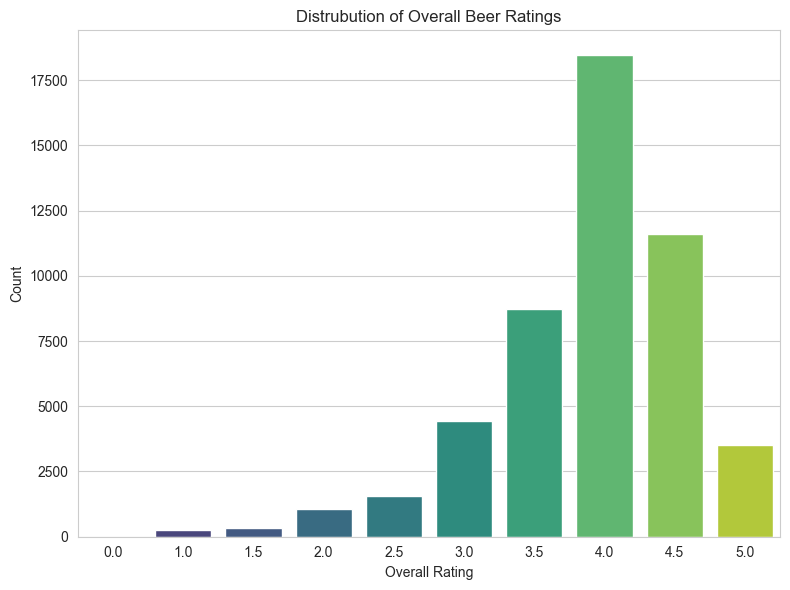

In [161]:
beer_overall_ratings = getDictOfCategoryAndCounts(data, 'review/overall')
print(beer_overall_ratings)
print(len(beer_overall_ratings))

categories = beer_overall_ratings.keys()
values = beer_overall_ratings.values()

weighted_sum = 0
total_count = 0
for rating in beer_overall_ratings:
    weighted_sum += rating * beer_overall_ratings[rating]
    total_count += beer_overall_ratings[rating]

print(weighted_sum/total_count)

# Setting the style (optional, for aesthetics)
sns.set_style('whitegrid')

# Creating the bar chart using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=categories, y=values, palette='viridis')

# Adding titles and labels
plt.title('Distrubution of Overall Beer Ratings')
plt.xlabel('Overall Rating')
plt.ylabel('Count')

# Displaying the chart
plt.tight_layout()  # Adjust layout to prevent cutting off labels
plt.show()

defaultdict(<class 'set'>, {'Hefeweizen': 618, 'English Strong Ale': 164, 'Foreign / Export Stout': 55, 'German Pilsener': 586, 'American Double / Imperial IPA': 3886, 'Herbed / Spiced Beer': 73, 'Oatmeal Stout': 102, 'American Pale Lager': 123, 'Rauchbier': 1938, 'American Pale Ale (APA)': 2288, 'American Porter': 2230, 'Belgian Strong Dark Ale': 146, 'Russian Imperial Stout': 2695, 'American Amber / Red Ale': 665, 'American Strong Ale': 166, 'MÃ¤rzen / Oktoberfest': 557, 'American Adjunct Lager': 242, 'American Blonde Ale': 357, 'American IPA': 4113, 'Fruit / Vegetable Beer': 1355, 'English Bitter': 267, 'English Porter': 367, 'Irish Dry Stout': 101, 'American Barleywine': 825, 'American Double / Imperial Stout': 5964, 'Doppelbock': 873, 'American Stout': 591, 'Maibock / Helles Bock': 225, 'Dortmunder / Export Lager': 31, 'Euro Strong Lager': 329, 'Low Alcohol Beer': 7, 'Light Lager': 503, 'Euro Pale Lager': 701, 'Bock': 148, 'English India Pale Ale (IPA)': 175, 'Altbier': 165, 'KÃ¶l

/var/folders/b3/fdd3r5fs7zq6m_ljpwlt1_h40000gn/T/ipykernel_47826/2788641234.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=categories, x=values, palette='viridis')


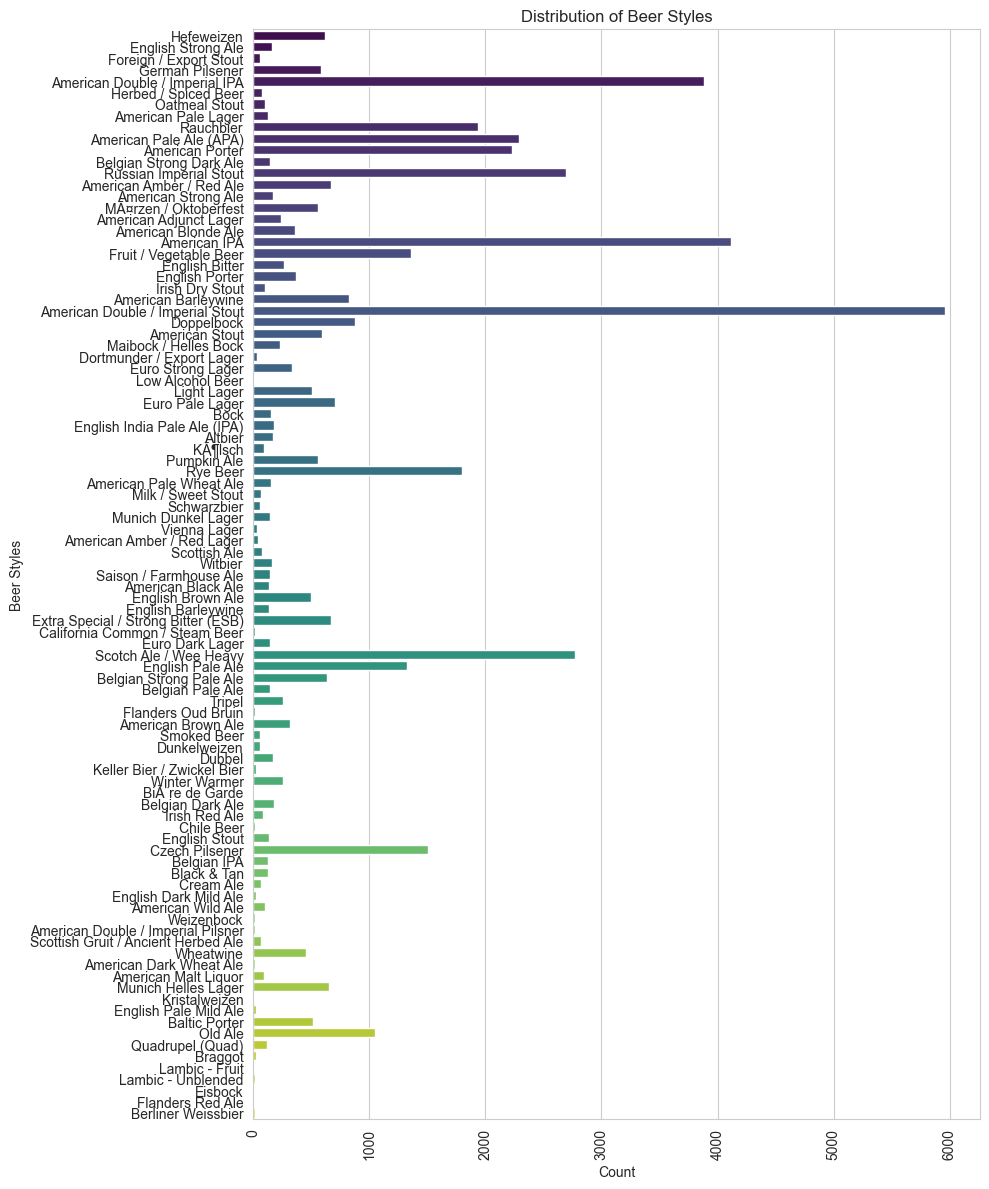

In [162]:
beer_types = getDictOfCategoryAndCounts(data, 'beer/style')
print(beer_types)
print(len(beer_types))

categories = beer_types.keys()
values = beer_types.values()

# Create a horizontal bar plot
plt.figure(figsize=(10, 12))  # Adjust figure size as needed
sns.barplot(y=categories, x=values, palette='viridis')

# Adding titles and labels
plt.title('Distribution of Beer Styles')
plt.xlabel('Count')
plt.ylabel('Beer Styles')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

defaultdict(<class 'set'>, {1.5: 343, 3.0: 4137, 4.5: 12883, 3.5: 8797, 4.0: 16575, 2.0: 1099, 5.0: 4331, 2.5: 1624, 1.0: 211, 0.0: 0})
10


/var/folders/b3/fdd3r5fs7zq6m_ljpwlt1_h40000gn/T/ipykernel_47826/2371977613.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories, y=values, palette='viridis')


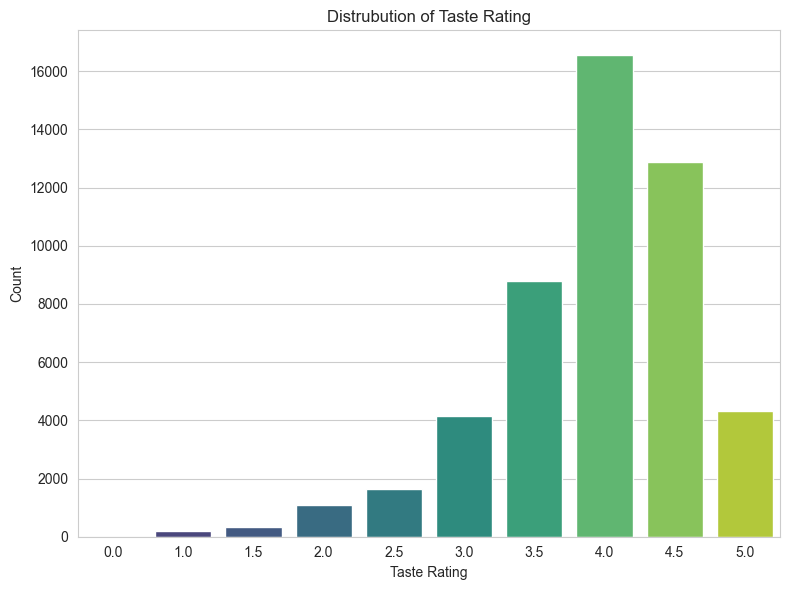

In [163]:
taste_reviews = getDictOfCategoryAndCounts(data, 'review/taste')
taste_reviews[0.0] = 0

print(taste_reviews)
print(len(taste_reviews))

categories = taste_reviews.keys()
values = taste_reviews.values()

# Setting the style (optional, for aesthetics)
sns.set_style('whitegrid')

# Creating the bar chart using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=categories, y=values, palette='viridis')

# Adding titles and labels
plt.title('Distrubution of Taste Rating')
plt.xlabel('Taste Rating')
plt.ylabel('Count')

# Displaying the chart
plt.tight_layout()  # Adjust layout to prevent cutting off labels
plt.show()

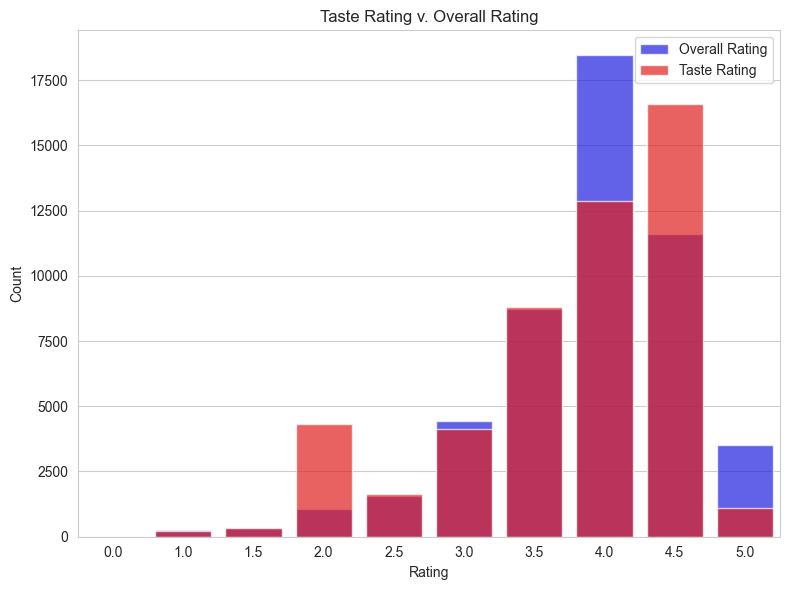

In [164]:
# Sample data for two sets of values
categories = beer_overall_ratings.keys()
values_set1 = beer_overall_ratings.values()
values_set2 = taste_reviews.values()

# Create bar plots for both sets of values
plt.figure(figsize=(8, 6))  # Set figure size

# Plotting the first set of values (blue bars)
sns.barplot(x=categories, y=values_set1, color='blue', alpha=.7, label='Overall Rating')

# Plotting the second set of values (orange bars, overlaying on the first)
sns.barplot(x=categories, y=values_set2, color='red', alpha=.7, label='Taste Rating')

# Adding legend, title, and labels
plt.legend()  # Show legend based on the labels provided in the plots
plt.title('Taste Rating v. Overall Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

defaultdict(<class 'set'>, {2009: 8773, 2010: 9686, 2012: 388, 2011: 11256, 2004: 1580, 2003: 1179, 2008: 6016, 2007: 4028, 2006: 3897, 2005: 2604, 2002: 539, 2001: 38, 2000: 11, 1999: 5})
14


/var/folders/b3/fdd3r5fs7zq6m_ljpwlt1_h40000gn/T/ipykernel_47826/3620248989.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories, y=values, palette='viridis')


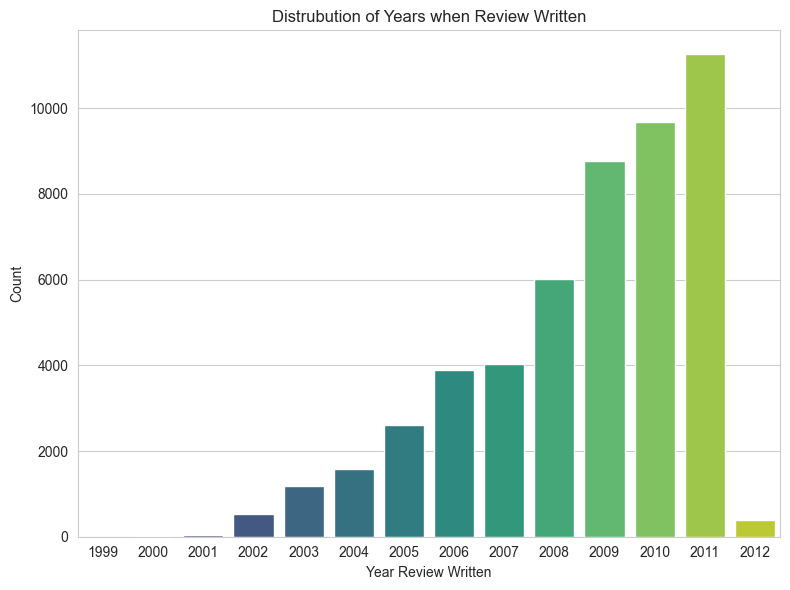

In [165]:
years = getDictOfTimeCategoryAndCounts(data, 'year')
print(years)
print(len(years))

categories = years.keys()
values = years.values()

# Setting the style (optional, for aesthetics)
sns.set_style('whitegrid')

# Creating the bar chart using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=categories, y=values, palette='viridis')

# Adding titles and labels
plt.title('Distrubution of Years when Review Written')
plt.xlabel('Year Review Written')
plt.ylabel('Count')

# Displaying the chart
plt.tight_layout()  # Adjust layout to prevent cutting off labels
plt.show()

defaultdict(<class 'set'>, {2: 3757, 3: 4374, 12: 4368, 1: 4341, 10: 4501, 5: 4061, 11: 4414, 9: 4085, 8: 4271, 6: 3750, 7: 4043, 4: 4035})
12
{1: 4341, 2: 3757, 3: 4374, 4: 4035, 5: 4061, 6: 3750, 7: 4043, 8: 4271, 9: 4085, 10: 4501, 11: 4414, 12: 4368}


/var/folders/b3/fdd3r5fs7zq6m_ljpwlt1_h40000gn/T/ipykernel_47826/1408820017.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories, y=values, palette='viridis')


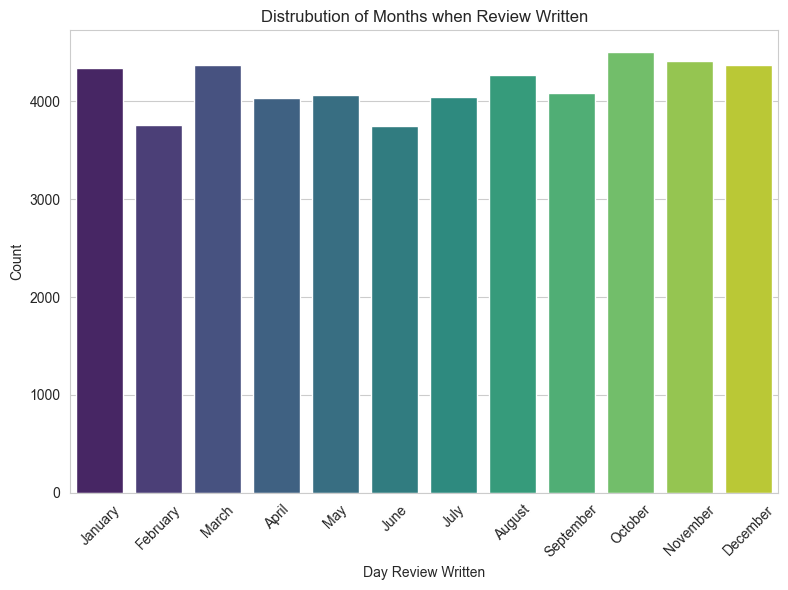

In [166]:
months = getDictOfTimeCategoryAndCounts(data, 'mon')
print(months)
print(len(months))

sorted_months = dict(sorted(months.items()))  # Sorting by keys
print(sorted_months)


categories = [calendar.month_name[x] for x in sorted_months.keys()]
values = sorted_months.values()

# Setting the style (optional, for aesthetics)
sns.set_style('whitegrid')

# Creating the bar chart using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=categories, y=values, palette='viridis')

# Adding titles and labels
plt.title('Distrubution of Months when Review Written')
plt.xlabel('Day Review Written')
plt.ylabel('Count')

# Displaying the chart
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to prevent cutting off labels
plt.show()

defaultdict(<class 'set'>, {0: 7148, 6: 7786, 3: 6897, 2: 6891, 1: 7066, 5: 7236, 4: 6976})
7
{0: 7148, 1: 7066, 2: 6891, 3: 6897, 4: 6976, 5: 7236, 6: 7786}


/var/folders/b3/fdd3r5fs7zq6m_ljpwlt1_h40000gn/T/ipykernel_47826/3106488132.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories, y=values, palette='viridis')


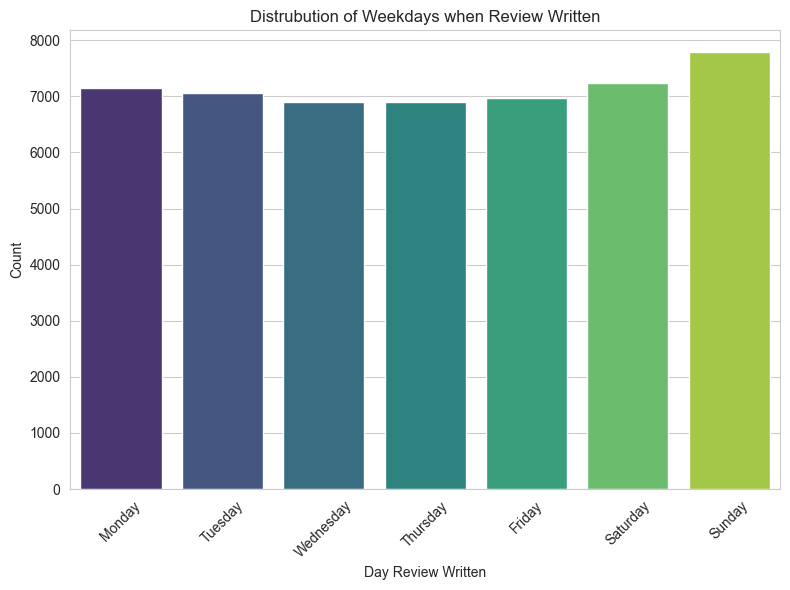

In [167]:
days = getDictOfTimeCategoryAndCounts(data, 'wday')
print(days)
print(len(days))

sorted_days = dict(sorted(days.items()))  # Sorting by keys
print(sorted_days)

categories = [calendar.day_name[x] for x in sorted_days.keys()]
values = sorted_days.values()

# Setting the style (optional, for aesthetics)
sns.set_style('whitegrid')

# Creating the bar chart using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x=categories, y=values, palette='viridis')

# Adding titles and labels
plt.title('Distrubution of Weekdays when Review Written')
plt.xlabel('Day Review Written')
plt.ylabel('Count')

# Displaying the chart
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to prevent cutting off labels
plt.show()

In [168]:
# profilesPerBeer maps each beer ID to a set of user profiles, e.g. {beer1 -> {userA, userB, userC}}
# beersPerProfile maps each user profile to a set of beer IDs, e.g. {userA -> {beer1, beer2, beer3}}
# beerIdToBeerNmae maps the beer ID to the name of the beer
profilesPerBeer, beersPerProfile, beerIdToBeerName = getProfilesAndBeerDicts(data)
print("Amount of users:", len(beersPerProfile))
print("Amount of beers:", len(profilesPerBeer))



Amount of users: 8376
Amount of beers: 1923


In [169]:
getMostAndLeastPopularBeers(data, beerIdToBeerName, 10)


[getMostAndLeastPopularBeers] Length of beer ratings dict: 416
The most popular beer is: ' Founders CBS Imperial Stout ' with an average rating of 4.5910518053375196
637 people reviewed this beer

The least popular beer is: ' Trafalgar Maple Bock ' with an average rating of 1.775
20 people reviewed this beer
